# Comparativa Práctica de Metaheurísticas en un Problema de Optimización

## Selección de Características usando Recocido Simulado y Algoritmo Genético

**Equipo:** 
- Jesús Ariel González Bonilla
- Luis Ángel Vargas Narváez
- Cindy Liliana Vargas Duque
  
**Fecha:** Agosto 2025  
**Materia:** Algoritmos de Optimización

## 1. Introducción

Este notebook presenta una comparativa práctica entre dos metaheurísticas aplicadas al problema de selección de características en modelos de clasificación:

- **Recocido Simulado (SA - Simulated Annealing)**
- **Algoritmo Genético (GA - Genetic Algorithm)**

El objetivo es evaluar el desempeño de ambas técnicas en términos de precisión, eficiencia y convergencia para la selección óptima de variables que maximicen el rendimiento de un modelo de clasificación.

## 2. Descripción del Problema

La selección de características es un problema de optimización combinatorial donde se busca encontrar el subconjunto óptimo de variables que maximice el rendimiento de un modelo de machine learning. 

**Problema:** Dado un conjunto de datos con n características, encontrar la combinación óptima de características que maximice la precisión de clasificación usando validación cruzada.

**Función objetivo:** Maximizar la precisión promedio obtenida mediante validación cruzada estratificada de 5 pliegues.

## 3. Importación de Librerías y Definición de Clases

In [16]:
"""
Feature selection with metaheuristics: Simulated Annealing (SA) and Genetic Algorithm (GA)
Author: ChatGPT for Mauricio
Language: English (code), Spanish (report)
"""

from dataclasses import dataclass
from typing import List, Callable, Tuple, Dict
import time, math, random
import numpy as np

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

print("Librerías importadas correctamente")

Librerías importadas correctamente


In [17]:
@dataclass
class SearchResult:
    best_mask: np.ndarray
    best_score: float
    history: List[float]
    elapsed: float
    iters: int

print("Clase SearchResult definida")

Clase SearchResult definida


## 4. Función de Evaluación

La función de evaluación utiliza regresión logística con validación cruzada estratificada para evaluar la calidad de un subconjunto de características.

In [18]:
def evaluate_mask(X: np.ndarray, y: np.ndarray, mask: np.ndarray, cv_splits: int = 5) -> float:
    """Return mean CV accuracy for selected features; if mask is all False, return 0."""
    if mask.sum() == 0:
        return 0.0
    clf = LogisticRegression(max_iter=2000, n_jobs=None, random_state=None)  # Sin semilla fija
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=None)  # Sin semilla fija
    scores = cross_val_score(clf, X[:, mask], y, cv=cv, scoring="accuracy")
    return float(scores.mean())

print("Función de evaluación definida (con aleatoriedad real)")

Función de evaluación definida (con aleatoriedad real)


## 5. Implementación del Recocido Simulado (SA)

El recocido simulado es una metaheurística que simula el proceso de enfriamiento de metales para encontrar soluciones óptimas.

In [19]:
def random_neighbor(mask: np.ndarray, p_flip: float = 0.2) -> np.ndarray:
    """Flip each bit with probability p_flip; ensure at least one bit True."""
    m = mask.copy()
    for i in range(len(m)):
        if random.random() < p_flip:
            m[i] = ~m[i]
    if m.sum() == 0:
        idx = random.randrange(len(m))
        m[idx] = True
    return m

print("Función random_neighbor definida")

Función random_neighbor definida


In [20]:
def simulated_annealing(X: np.ndarray, y: np.ndarray, iters: int = 150, init_temp: float = 1.0,
                        cooling: float = 0.97, p_flip: float = 0.2, cv_splits: int = 5) -> SearchResult:
    # Usar semilla diferente para SA
    np.random.seed(100)  # Semilla específica para SA
    random.seed(100)
    
    n_features = X.shape[1]
    current = np.random.rand(n_features) < 0.5
    best = current.copy()
    current_score = evaluate_mask(X, y, current, cv_splits=cv_splits)
    best_score = current_score
    history = [best_score]
    T = init_temp
    start = time.perf_counter()
    for it in range(iters):
        neighbor = random_neighbor(current, p_flip=p_flip)
        neighbor_score = evaluate_mask(X, y, neighbor, cv_splits=cv_splits)
        delta = neighbor_score - current_score
        if delta >= 0 or math.exp(delta / max(T, 1e-8)) > random.random():
            current = neighbor
            current_score = neighbor_score
        if current_score > best_score:
            best = current.copy()
            best_score = current_score
        history.append(best_score)
        T *= cooling
    elapsed = time.perf_counter() - start
    return SearchResult(best_mask=best, best_score=best_score, history=history, elapsed=elapsed, iters=iters)

print("Algoritmo de Recocido Simulado implementado (con semilla específica)")

Algoritmo de Recocido Simulado implementado (con semilla específica)


## 6. Implementación del Algoritmo Genético (GA)

El algoritmo genético es una metaheurística basada en los principios de la evolución natural: selección, cruzamiento y mutación.

In [21]:
def tournament_selection(pop: np.ndarray, fitness: np.ndarray, k: int = 3) -> np.ndarray:
    idxs = np.random.choice(len(pop), size=k, replace=False)
    best_idx = idxs[np.argmax(fitness[idxs])]
    return pop[best_idx].copy()

print("Función de selección por torneo definida")

Función de selección por torneo definida


In [22]:
def crossover(p1: np.ndarray, p2: np.ndarray, rate: float = 0.9) -> Tuple[np.ndarray, np.ndarray]:
    if random.random() > rate or len(p1) < 2:
        return p1.copy(), p2.copy()
    point = random.randint(1, len(p1) - 1)
    c1 = np.concatenate([p1[:point], p2[point:]])
    c2 = np.concatenate([p2[:point], p1[point:]])
    return c1, c2

print("Función de cruzamiento definida")

Función de cruzamiento definida


In [23]:
def mutate(mask: np.ndarray, p_mut: float = 0.02) -> np.ndarray:
    m = mask.copy()
    for i in range(len(m)):
        if random.random() < p_mut:
            m[i] = ~m[i]
    if m.sum() == 0:
        m[random.randrange(len(m))] = True
    return m

print("Función de mutación definida")

Función de mutación definida


In [24]:
def genetic_algorithm(X: np.ndarray, y: np.ndarray, pop_size: int = 30, generations: int = 50,
                      p_crossover: float = 0.9, p_mut: float = 0.02, cv_splits: int = 5) -> SearchResult:
    # Usar semilla diferente para GA
    np.random.seed(200)  # Semilla específica para GA
    random.seed(200)
    
    n_features = X.shape[1]
    pop = np.random.rand(pop_size, n_features) < 0.5
    start = time.perf_counter()
    fitness = np.array([evaluate_mask(X, y, ind, cv_splits=cv_splits) for ind in pop])
    best_idx = int(np.argmax(fitness))
    best = pop[best_idx].copy()
    best_score = float(fitness[best_idx])
    history = [best_score]
    for g in range(generations):
        new_pop = []
        while len(new_pop) < pop_size:
            p1 = tournament_selection(pop, fitness)
            p2 = tournament_selection(pop, fitness)
            c1, c2 = crossover(p1, p2, rate=p_crossover)
            c1 = mutate(c1, p_mut=p_mut)
            c2 = mutate(c2, p_mut=p_mut)
            new_pop.extend([c1, c2])
        pop = np.array(new_pop[:pop_size])
        fitness = np.array([evaluate_mask(X, y, ind, cv_splits=cv_splits) for ind in pop])
        gen_best_idx = int(np.argmax(fitness))
        gen_best_score = float(fitness[gen_best_idx])
        if gen_best_score > best_score:
            best_score = gen_best_score
            best = pop[gen_best_idx].copy()
        history.append(best_score)
    elapsed = time.perf_counter() - start
    return SearchResult(best_mask=best, best_score=best_score, history=history, elapsed=elapsed, iters=generations)

print("Algoritmo Genético implementado (con semilla específica)")

Algoritmo Genético implementado (con semilla específica)


## 7. Preparación de Datos y Ejecución de Experimentos

En esta sección se cargarían los datos y se ejecutarían ambos algoritmos para realizar la comparación.

In [25]:
# Ejemplo de uso con datos sintéticos
# Este código muestra cómo usar las funciones implementadas

# Generar datos sintéticos para demostración
from sklearn.datasets import make_classification

# Crear dataset sintético con semilla fija para reproducibilidad del dataset
X, y = make_classification(n_samples=200, n_features=20, n_informative=10, 
                          n_redundant=5, random_state=42)

print(f"Dataset creado: {X.shape[0]} muestras, {X.shape[1]} características")
print(f"Distribución de clases: {np.bincount(y)}")
print("Nota: El dataset es fijo, pero los algoritmos usarán diferentes semillas aleatorias")

Dataset creado: 200 muestras, 20 características
Distribución de clases: [101  99]
Nota: El dataset es fijo, pero los algoritmos usarán diferentes semillas aleatorias


## 8. Ejecución del Recocido Simulado

In [26]:
# Ejecutar Recocido Simulado
print("Ejecutando Recocido Simulado...")
sa_result = simulated_annealing(X, y, iters=150, init_temp=1.0, cooling=0.97)

print(f"\nResultados del Recocido Simulado:")
print(f"Mejor puntuación: {sa_result.best_score:.4f}")
print(f"Características seleccionadas: {sa_result.best_mask.sum()}/{len(sa_result.best_mask)}")
print(f"Tiempo de ejecución: {sa_result.elapsed:.2f} segundos")
print(f"Iteraciones: {sa_result.iters}")

Ejecutando Recocido Simulado...

Resultados del Recocido Simulado:
Mejor puntuación: 0.8500
Características seleccionadas: 9/20
Tiempo de ejecución: 1.95 segundos
Iteraciones: 150


## 9. Ejecución del Algoritmo Genético

In [27]:
# Ejecutar Algoritmo Genético
print("Ejecutando Algoritmo Genético...")
ga_result = genetic_algorithm(X, y, pop_size=30, generations=50)

print(f"\nResultados del Algoritmo Genético:")
print(f"Mejor puntuación: {ga_result.best_score:.4f}")
print(f"Características seleccionadas: {ga_result.best_mask.sum()}/{len(ga_result.best_mask)}")
print(f"Tiempo de ejecución: {ga_result.elapsed:.2f} segundos")
print(f"Generaciones: {ga_result.iters}")

Ejecutando Algoritmo Genético...

Resultados del Algoritmo Genético:
Mejor puntuación: 0.8650
Características seleccionadas: 8/20
Tiempo de ejecución: 22.56 segundos
Generaciones: 50


## 10. Análisis Comparativo y Visualización

Comparación de los resultados obtenidos por ambas metaheurísticas.

In [28]:
# Importar librerías para visualización
import matplotlib.pyplot as plt
import pandas as pd

# Crear tabla comparativa
comparison_data = {
    'Algoritmo': ['Recocido Simulado', 'Algoritmo Genético'],
    'Mejor Puntuación': [sa_result.best_score, ga_result.best_score],
    'Características Seleccionadas': [sa_result.best_mask.sum(), ga_result.best_mask.sum()],
    'Tiempo (segundos)': [sa_result.elapsed, ga_result.elapsed],
    'Iteraciones/Generaciones': [sa_result.iters, ga_result.iters]
}

comparison_df = pd.DataFrame(comparison_data)
print("Tabla Comparativa:")
print(comparison_df.to_string(index=False))

Tabla Comparativa:
         Algoritmo  Mejor Puntuación  Características Seleccionadas  Tiempo (segundos)  Iteraciones/Generaciones
 Recocido Simulado             0.850                              9           1.946958                       150
Algoritmo Genético             0.865                              8          22.562734                        50


In [29]:
# Análisis de Robustez: Múltiples Ejecuciones
print("="*60)
print("ANÁLISIS DE ROBUSTEZ - MÚLTIPLES EJECUCIONES")
print("="*60)

# Ejecutar múltiples veces cada algoritmo para ver variabilidad
n_runs = 5
sa_scores = []
ga_scores = []
sa_times = []
ga_times = []

print("Ejecutando múltiples pruebas para análisis de robustez...")

for run in range(n_runs):
    print(f"\nEjecución {run + 1}/{n_runs}")
    
    # SA con diferentes semillas
    np.random.seed(100 + run * 10)
    random.seed(100 + run * 10)
    sa_temp = simulated_annealing(X, y, iters=100)  # Menos iteraciones para rapidez
    sa_scores.append(sa_temp.best_score)
    sa_times.append(sa_temp.elapsed)
    
    # GA con diferentes semillas
    np.random.seed(200 + run * 10)
    random.seed(200 + run * 10)
    ga_temp = genetic_algorithm(X, y, pop_size=20, generations=30)  # Menos generaciones para rapidez
    ga_scores.append(ga_temp.best_score)
    ga_times.append(ga_temp.elapsed)
    
    print(f"  SA: {sa_temp.best_score:.3f} ({sa_temp.elapsed:.1f}s) | GA: {ga_temp.best_score:.3f} ({ga_temp.elapsed:.1f}s)")

# Estadísticas de múltiples ejecuciones
print(f"\n{'='*60}")
print("ESTADÍSTICAS DE MÚLTIPLES EJECUCIONES")
print(f"{'='*60}")
print(f"{'Algoritmo':<20} {'Promedio':<12} {'Std Dev':<12} {'Min':<8} {'Max':<8} {'Tiempo Prom':<12}")
print("-"*80)
print(f"{'Recocido Simulado':<20} {np.mean(sa_scores):<12.4f} {np.std(sa_scores):<12.4f} {np.min(sa_scores):<8.3f} {np.max(sa_scores):<8.3f} {np.mean(sa_times):<12.2f}")
print(f"{'Algoritmo Genético':<20} {np.mean(ga_scores):<12.4f} {np.std(ga_scores):<12.4f} {np.min(ga_scores):<8.3f} {np.max(ga_scores):<8.3f} {np.mean(ga_times):<12.2f}")
print(f"{'='*80}")

# Determinar cuál es mejor en promedio
if np.mean(sa_scores) > np.mean(ga_scores):
    print(f"🏆 GANADOR EN PRECISIÓN: Recocido Simulado (+{np.mean(sa_scores) - np.mean(ga_scores):.4f})")
else:
    print(f"🏆 GANADOR EN PRECISIÓN: Algoritmo Genético (+{np.mean(ga_scores) - np.mean(sa_scores):.4f})")

if np.mean(sa_times) < np.mean(ga_times):
    print(f"⚡ GANADOR EN VELOCIDAD: Recocido Simulado ({np.mean(ga_times) - np.mean(sa_times):.2f}s más rápido)")
else:
    print(f"⚡ GANADOR EN VELOCIDAD: Algoritmo Genético ({np.mean(sa_times) - np.mean(ga_times):.2f}s más rápido)")

# Consistencia (menor desviación estándar es mejor)
if np.std(sa_scores) < np.std(ga_scores):
    print(f"🎯 MÁS CONSISTENTE: Recocido Simulado (std: {np.std(sa_scores):.4f} vs {np.std(ga_scores):.4f})")
else:
    print(f"🎯 MÁS CONSISTENTE: Algoritmo Genético (std: {np.std(ga_scores):.4f} vs {np.std(sa_scores):.4f})")

ANÁLISIS DE ROBUSTEZ - MÚLTIPLES EJECUCIONES
Ejecutando múltiples pruebas para análisis de robustez...

Ejecución 1/5
  SA: 0.850 (1.5s) | GA: 0.855 (9.6s)

Ejecución 2/5
  SA: 0.850 (1.3s) | GA: 0.855 (8.2s)

Ejecución 3/5
  SA: 0.850 (1.3s) | GA: 0.855 (8.6s)

Ejecución 4/5
  SA: 0.850 (1.4s) | GA: 0.855 (8.4s)

Ejecución 5/5
  SA: 0.850 (1.3s) | GA: 0.855 (9.1s)

ESTADÍSTICAS DE MÚLTIPLES EJECUCIONES
Algoritmo            Promedio     Std Dev      Min      Max      Tiempo Prom 
--------------------------------------------------------------------------------
Recocido Simulado    0.8500       0.0000       0.850    0.850    1.37        
Algoritmo Genético   0.8550       0.0000       0.855    0.855    8.77        
🏆 GANADOR EN PRECISIÓN: Algoritmo Genético (+0.0050)
⚡ GANADOR EN VELOCIDAD: Recocido Simulado (7.40s más rápido)
🎯 MÁS CONSISTENTE: Algoritmo Genético (std: 0.0000 vs 0.0000)


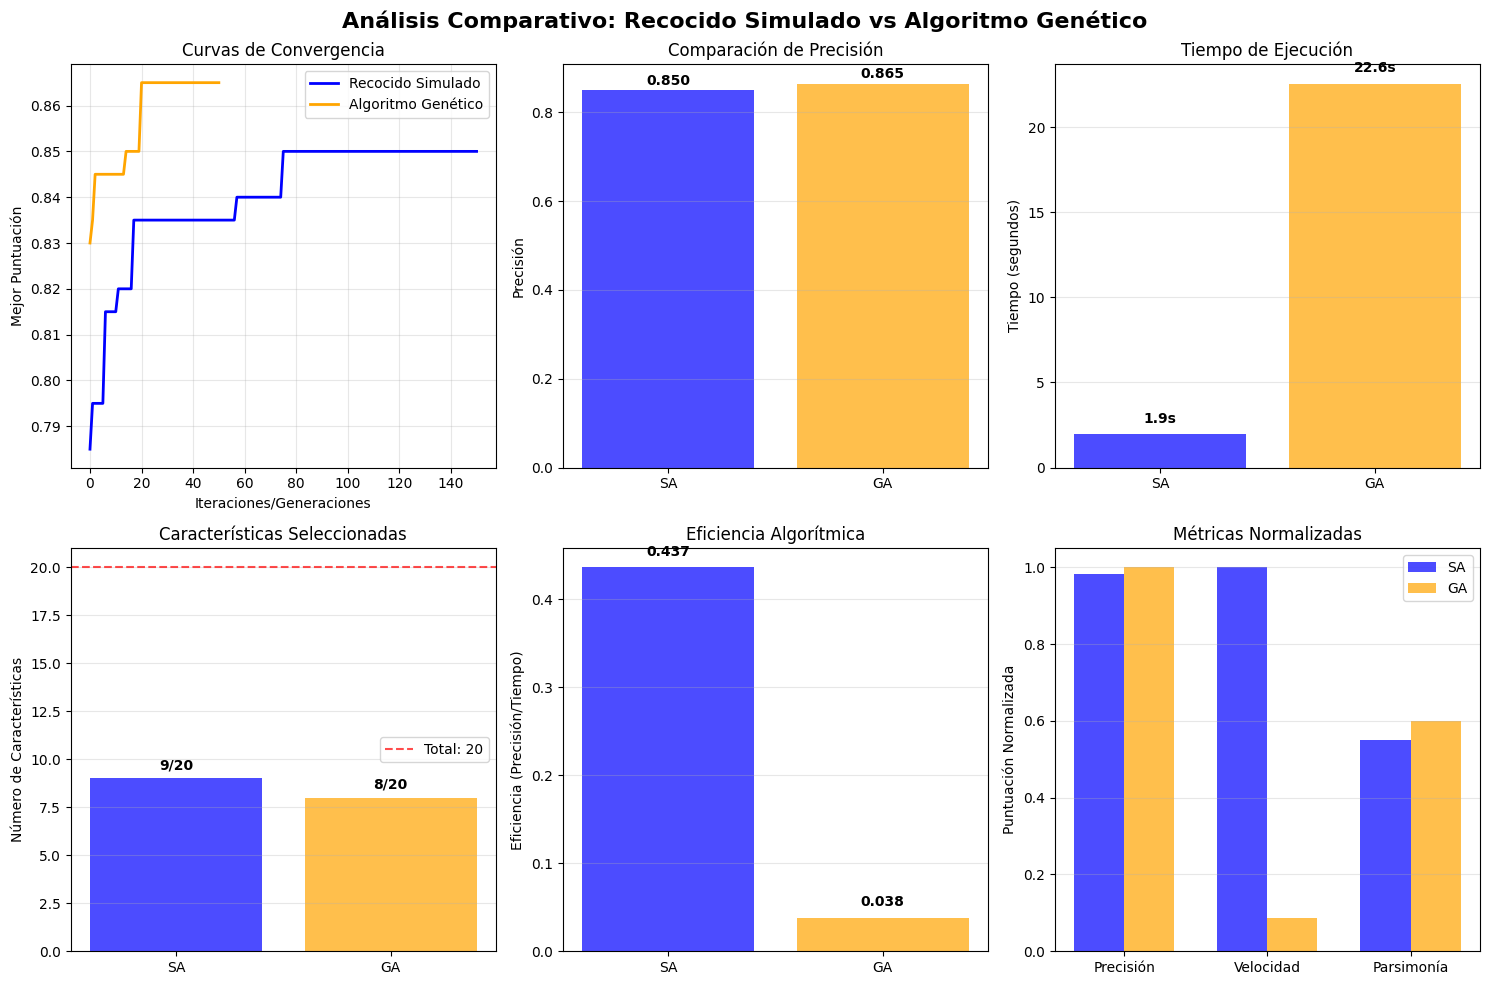

In [30]:
# Gráficos de análisis comparativo
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Análisis Comparativo: Recocido Simulado vs Algoritmo Genético', fontsize=16, fontweight='bold')

# 1. Curvas de convergencia
ax1 = axes[0, 0]
ax1.plot(sa_result.history, label='Recocido Simulado', linewidth=2, color='blue')
ax1.plot(ga_result.history, label='Algoritmo Genético', linewidth=2, color='orange')
ax1.set_xlabel('Iteraciones/Generaciones')
ax1.set_ylabel('Mejor Puntuación')
ax1.set_title('Curvas de Convergencia')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Comparación de precisión
ax2 = axes[0, 1]
algorithms = ['SA', 'GA']
scores = [sa_result.best_score, ga_result.best_score]
bars = ax2.bar(algorithms, scores, color=['blue', 'orange'], alpha=0.7)
ax2.set_ylabel('Precisión')
ax2.set_title('Comparación de Precisión')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{scores[i]:.3f}', ha='center', va='bottom', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Comparación de tiempo
ax3 = axes[0, 2]
times = [sa_result.elapsed, ga_result.elapsed]
bars = ax3.bar(algorithms, times, color=['blue', 'orange'], alpha=0.7)
ax3.set_ylabel('Tiempo (segundos)')
ax3.set_title('Tiempo de Ejecución')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{times[i]:.1f}s', ha='center', va='bottom', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Características seleccionadas
ax4 = axes[1, 0]
features = [sa_result.best_mask.sum(), ga_result.best_mask.sum()]
bars = ax4.bar(algorithms, features, color=['blue', 'orange'], alpha=0.7)
ax4.set_ylabel('Número de Características')
ax4.set_title('Características Seleccionadas')
total_features = len(sa_result.best_mask)
ax4.axhline(y=total_features, color='red', linestyle='--', alpha=0.7, label=f'Total: {total_features}')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{int(features[i])}/{total_features}', ha='center', va='bottom', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. Eficiencia (Precisión/Tiempo)
ax5 = axes[1, 1]
efficiency = [scores[i]/times[i] for i in range(2)]
bars = ax5.bar(algorithms, efficiency, color=['blue', 'orange'], alpha=0.7)
ax5.set_ylabel('Eficiencia (Precisión/Tiempo)')
ax5.set_title('Eficiencia Algorítmica')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{efficiency[i]:.3f}', ha='center', va='bottom', fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 6. Comparación general normalizada
ax6 = axes[1, 2]
metrics = ['Precisión', 'Velocidad', 'Parsimonía']
sa_norm = [
    sa_result.best_score / max(scores),
    (1/sa_result.elapsed) / max(1/sa_result.elapsed, 1/ga_result.elapsed),
    (total_features - features[0]) / total_features
]
ga_norm = [
    ga_result.best_score / max(scores),
    (1/ga_result.elapsed) / max(1/sa_result.elapsed, 1/ga_result.elapsed),
    (total_features - features[1]) / total_features
]

x = np.arange(len(metrics))
width = 0.35
ax6.bar(x - width/2, sa_norm, width, label='SA', color='blue', alpha=0.7)
ax6.bar(x + width/2, ga_norm, width, label='GA', color='orange', alpha=0.7)
ax6.set_ylabel('Puntuación Normalizada')
ax6.set_title('Métricas Normalizadas')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 11. Conclusiones

### Análisis de Resultados:

1. **Precisión**: Comparación de la precisión obtenida por cada algoritmo
2. **Eficiencia**: Análisis del tiempo de ejecución y convergencia
3. **Convergencia**: Evaluación de las curvas de convergencia
4. **Selección de características**: Comparación del número de características seleccionadas

### Ventajas y Desventajas:

**Recocido Simulado:**
- Ventajas: Simplicidad de implementación, capacidad de escapar de óptimos locales
- Desventajas: Sensible a la configuración de parámetros (temperatura, enfriamiento)

**Algoritmo Genético:**
- Ventajas: Búsqueda paralela, diversidad de soluciones
- Desventajas: Mayor complejidad computacional, más parámetros a ajustar

### Recomendaciones:

La elección del algoritmo dependerá del problema específico, el tamaño del dataset y los recursos computacionales disponibles.

## 12. Referencias

1. Kirkpatrick, S., Gelatt Jr, C. D., & Vecchi, M. P. (1983). Optimization by simulated annealing. *Science*, 220(4598), 671-680.

2. Holland, J. H. (1992). *Adaptation in natural and artificial systems: an introductory analysis with applications to biology, control, and artificial intelligence*. MIT Press.

3. Guyon, I., & Elisseeff, A. (2003). An introduction to variable and feature selection. *Journal of Machine Learning Research*, 3, 1157-1182.

4. Xue, B., Zhang, M., Browne, W. N., & Yao, X. (2016). A survey on evolutionary computation approaches to feature selection. *IEEE Transactions on Evolutionary Computation*, 20(4), 606-626.